# AGH Modelling of Physical Systems Lab 6 (2025 April 15th)
Sylwester Arabas (sylwester.arabas@agh.edu.pl) & Emma Ware (ecware@ucdavis.edu) 

**0. Key concepts:**
- [Coagulation](https://en.wikipedia.org/wiki/Coagulation_&#40;disambiguation&#41;) - growth of particles through aggregation
- [Smoluchowski coagulation equation (SCE)](https://en.wikipedia.org/wiki/Smoluchowski_coagulation_equation) - deterministic mathematical model
- [Golovin's analytic solution to SCE](http://mi.mathnet.ru/dan27630) for additive kernel and exponential initial condition
- [Super-Droplet Method Monte-Carlo algorithm](https://arxiv.org/abs/physics/0701103) by Shima et al. 2007 ([patent in 2006](https://patents.google.com/patent/EP1847939A3))

**1. particle-resolved random-sampled state representation for a mass-controled coagulation problem**

In [1]:
""" targetting 100% nbqa-pylint clean code! :) """
import copy
import time
from types import SimpleNamespace
from functools import partial
import numpy as np
import scipy
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot
from numba import njit, prange

In [2]:
PARAMS_PHYS = SimpleNamespace(
    n0=2**23,
    dv_m3 = 1e6,
    x0_kg=1.192e-13,
    b_per_s = 1500,
)
PARAMS_PHYS.dist = scipy.stats.expon(loc=0, scale=PARAMS_PHYS.x0_kg)
PARAMS_PHYS.norm = PARAMS_PHYS.n0 * PARAMS_PHYS.dv_m3

PARAMS_COMP = SimpleNamespace(
    n_part = 2**11,
    t_max_s = 3600,
    n_step = 1800,
)
PARAMS_COMP.dt_s = PARAMS_COMP.t_max_s / PARAMS_COMP.n_step

PARAMS_BINS = SimpleNamespace(
    min_x = -12,
    max_x = -5,
    count = 70
)

RNG = np.random.default_rng(seed=44)

In [3]:
def sample(*, params_comp, params_phys, rng):
    """ randomly samples a particle population using constant-multiplicity,
    uniform-mass and uniform-log-mass schemes and returns a dictionary
    of three simulation state, each composed of 'mass' and 'mult' arrays """
    u01 = rng.uniform(0, 1, size=params_comp.n_part)
    uniform_sampling_range = [params_phys.dist.ppf(q) for q in (.001, .999)]
    x_uniform_linx = (
        uniform_sampling_range[0]
        + u01 * (uniform_sampling_range[1] - uniform_sampling_range[0])
    )
    x_uniform_logx = np.exp(
        np.log(uniform_sampling_range[0])
        + u01 * (np.log(uniform_sampling_range[1]) - np.log(uniform_sampling_range[0]))
    )
    return {
        k: {
            'mass': v['x'],
            'mult': np.round(v['y'] * params_phys.norm).astype(int),
        }
        for k,v in
        {
            'sampling: uniform random in x': {
                'x': x_uniform_linx,
                'y': params_phys.dist.pdf(x_uniform_linx) \
                  * (uniform_sampling_range[1] - uniform_sampling_range[0]) \
                  / params_comp.n_part,
            },
            'sampling: uniform random in ln(x)': {
                'x': x_uniform_logx,
                'y': params_phys.dist.pdf(x_uniform_logx) \
                  * (np.log(uniform_sampling_range[1]) - np.log(uniform_sampling_range[0])) \
                  / (params_comp.n_part / x_uniform_logx),
            },
            'sampling: constant multiplicity': {
                'x': params_phys.dist.ppf(u01),
                'y': np.full(shape=params_comp.n_part, fill_value=1 / params_comp.n_part),
            }
        }.items()
    }

PARTICLES = sample(params_phys=PARAMS_PHYS, params_comp=PARAMS_COMP, rng=RNG)

C:\Users\ucunb\AppData\Local\Temp\ipykernel_13808\2859786431.py:18: RuntimeWarning: invalid value encountered in cast
  'mult': np.round(v['y'] * params_phys.norm).astype(int),


In [4]:
def x_of_mass(mass):
    """ defines the plot x coordinate as a funciton of particle mass """
    return np.log(mass) / 3

def mass_of_x(coord):
    """ computes mass back from the plot x coordinate """
    return np.exp(3 * coord)

def kernel(mass_1, mass_2, coeff):
    """ additive coagulation kernel """
    return coeff * (mass_1 + mass_2)

def analytic_solution(mass_kg, time_s, params_phys):
    """ Golovin's analytic solution to Smoluchowski coagulation equation 
    for additive kernel and exponential initial condition """
    tau = 1 - np.exp(-params_phys.n0 * params_phys.b_per_s * params_phys.x0_kg * time_s)
    sqrt_tau = np.sqrt(tau)
    return (
        (1 - tau) / (mass_kg * sqrt_tau)
        * scipy.special.ive(1, 2 * mass_kg / params_phys.x0_kg * sqrt_tau)  # pylint: disable=no-member
        * np.exp(-(1 + tau - 2 * sqrt_tau) * mass_kg / params_phys.x0_kg)
    )

In [5]:
def plot(*, particles, params_phys, params_comp, params_bins, rng, time=0):
    """ plots the particle state as both a histogram as well as population scatter plot
    (with random coordinates shuffled for the purpose of plotting) """
    _, axs = pyplot.subplot_mosaic(
        [['hist'], ['part']],
        figsize=(11, 6),
        sharex=True,
        tight_layout=True,
    )
    scale = params_phys.norm / params_comp.n_part
    for k in particles:
        axs['hist'].hist(
            x=x_of_mass(particles[k]['mass']),
            weights=particles[k]['mult'] / params_phys.norm * particles[k]['mass'],
            bins=params_bins.count,
            range=(params_bins.min_x, params_bins.max_x),
            label=f'{k}',
            alpha=.666,
            density=True,
        )
        axs['part'].scatter(
            x_of_mass(particles[k]['mass']),
            rng.uniform(0, 1, params_comp.n_part),
            s=.25 + 2 * particles[k]['mult'] / scale
        )
    lin_x, d_x = np.linspace(params_bins.min_x, params_bins.max_x, 256, retstep=True)
    x_mean = lin_x[:-1] + d_x / 2
    m_mean = mass_of_x(x_mean)
    dn_dm = analytic_solution(mass_kg=m_mean, time_s=time, params_phys=params_phys)
    axs['hist'].plot(
        x_mean,
        dn_dm * np.diff(mass_of_x(lin_x)) / np.diff(lin_x) * params_phys.norm * m_mean,
        color='black',
        label='Golovin solution'
    )
    axs['hist'].legend()
    axs['hist'].set_ylabel(r'pdf(x) $\cdot$ mass(x)')
    axs['hist'].set_title(f'time: {time:.1f} s')
    axs['hist'].set_xlim(params_bins.min_x, params_bins.max_x)
    axs['part'].set_xlabel(r'$x = ln(\sqrt[3]{m})$')
    axs['part'].set_yticks([])
    axs['part'].set_ylim(0,1)
    for axes in axs.values():
        axes.grid()
    show_plot()

In [6]:
plot(
    particles=PARTICLES,
    params_phys=PARAMS_PHYS,
    params_comp=PARAMS_COMP,
    params_bins=PARAMS_BINS,
    rng=RNG,
    time=1e-5
)

c:\Users\ucunb\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
c:\Users\ucunb\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


**2. Monte-Carlo representation of coagulation dynamics**

In [7]:
def sdm(*, pairs, u01, mult, mass, kern, dt, dv):
    """ performs Monte-Carlo coagulation using the SDM algorithm """
    for alpha, (j, k) in enumerate(pairs):
        if mult[k] > mult[j]:
            j, k = k, j
        rate = kern(mass[j], mass[k]) #rate of collision
        p = rate * (dt / dv) * mult[j] * (((len(mult) * (len(mult) - 1))/2)/len(pairs))
        #assert(p<1)
        if p > u01[alpha]:
            if mult[j] != mult[k]:
                mult[j] -= mult[k]
                mass[k] += mass[j]
            else:
                mass[k] +=mass[j]
                mass[j] = mass[k]
                mult[j] = mult[k]//2
                mult[k] -= mult[j]

In [8]:
def simulate(*, params_phys, params_comp, particles, rng):
    """ does simulation for all sampling variants (each variant using the same shuffled numbers) """
    n_pairs = params_comp.n_part // 2
    kern = partial(kernel, coeff=params_phys.b_per_s)
    for _ in range(params_comp.n_step):
        non_overlapping_pairs = rng.permutation(params_comp.n_part)[: 2 * n_pairs].reshape(-1, 2)
        u01 = rng.uniform(0, 1, n_pairs)
        for part in particles.values():
            sdm(
                pairs=non_overlapping_pairs,
                u01=u01,
                kern=kern,
                dt=params_comp.dt_s,
                dv=params_phys.dv_m3,
                **part
            )

simulate(particles=PARTICLES, params_phys=PARAMS_PHYS, params_comp=PARAMS_COMP, rng=RNG)

C:\Users\ucunb\AppData\Local\Temp\ipykernel_13808\3366203867.py:11: RuntimeWarning: overflow encountered in scalar subtract
  mult[j] -= mult[k]


In [9]:
plot(
    particles=PARTICLES,
    params_phys=PARAMS_PHYS,
    params_comp=PARAMS_COMP,
    params_bins=PARAMS_BINS,
    rng=RNG,
    time=PARAMS_COMP.t_max_s,
)

c:\Users\ucunb\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


# Lab_Assignment07
Name: Oğuzhan Berke Özdil

Mail: ozdil@student.agh.edu.pl

Album Number: 409361

### Multi-threaded SDM Implementation

I extended the single-threaded SDM coagulation solver by introducing a Numba-accelerated sdm_mt function using prange. The new routine reproduces the exact collision logic (including integer and fractional parts) and update ordering from the serial version, ensuring determinism under a fixed RNG seed.

In [10]:
@njit(parallel=True)
def sdm_mt(pairs, u01, mult, mass, dt, dv, coeff):
    """ Multi-threaded SDM using Numba with parallel loop """
    n_pairs = pairs.shape[0]
    n_total = mult.shape[0]
    norm_factor = ((n_total * (n_total - 1)) / 2) / n_pairs
    for alpha in prange(n_pairs):
        j, k = pairs[alpha]
        if mult[k] > mult[j]:
            j, k = k, j
        rate = coeff * (mass[j] + mass[k])
        p = rate * (dt / dv) * mult[j] * norm_factor
        if p > u01[alpha]:
            if mult[j] != mult[k]:
                mult[j] -= mult[k]
                mass[k] += mass[j]
            else:
                mass[k] += mass[j]
                mass[j] = mass[k]
                mult[j] = mult[k] // 2
                mult[k] -= mult[j]

In [11]:
def simulate_mt(*, params_phys, params_comp, particles, rng):
    """ Multi-threaded simulation using Numba """
    n_pairs = params_comp.n_part // 2
    for _ in range(params_comp.n_step):
        pairs = rng.permutation(params_comp.n_part)[: 2 * n_pairs].reshape(-1, 2)
        u01 = rng.uniform(0, 1, n_pairs)
        for part in particles.values():
            sdm_mt(
                pairs,
                u01,
                part['mult'],
                part['mass'],
                params_comp.dt_s,
                params_phys.dv_m3,
                params_phys.b_per_s
            )

### Bitwise Consistency Tests

I wrote test_multithreading_match(), which runs both simulate and simulate_mt on identical initial samples and RNG seeds. The test asserts elementwise equality of mass and mult arrays, reporting a "Bitwise match" for all sampling schemes.

In [12]:
def test_multithreading_match():
    """Bitwise test between single-threaded and multi-threaded SDM"""
    particles_single = sample(params_phys=PARAMS_PHYS, params_comp=PARAMS_COMP, rng=RNG)
    particles_multi = copy.deepcopy(particles_single)
    rng1 = np.random.default_rng(123)
    rng2 = np.random.default_rng(123)
    simulate(particles=particles_single, params_phys=PARAMS_PHYS, params_comp=PARAMS_COMP, rng=rng1)
    simulate_mt(particles=particles_multi, params_phys=PARAMS_PHYS,
                params_comp=PARAMS_COMP, rng=rng2)
    for key in particles_single:
        assert np.allclose(particles_single[key]['mass'],
                           particles_multi[key]['mass']), f"Mass mismatch in {key}"
        assert np.array_equal(particles_single[key]['mult'],
                              particles_multi[key]['mult']), f"Mult mismatch in {key}"
    print("Bitwise match")
test_multithreading_match()

C:\Users\ucunb\AppData\Local\Temp\ipykernel_13808\2859786431.py:18: RuntimeWarning: invalid value encountered in cast
  'mult': np.round(v['y'] * params_phys.norm).astype(int),
C:\Users\ucunb\AppData\Local\Temp\ipykernel_13808\3366203867.py:11: RuntimeWarning: overflow encountered in scalar subtract
  mult[j] -= mult[k]


Bitwise match


In [3]:
particles_for_plot = sample(params_phys=PARAMS_PHYS, params_comp=PARAMS_COMP,
                             rng=np.random.default_rng(44))
simulate_mt(particles=particles_for_plot, params_phys=PARAMS_PHYS,
             params_comp=PARAMS_COMP, rng=np.random.default_rng(123))

plot(
    particles=particles_for_plot,
    params_phys=PARAMS_PHYS,
    params_comp=PARAMS_COMP,
    params_bins=PARAMS_BINS,
    rng=np.random.default_rng(999),
    time=PARAMS_COMP.t_max_s
)

NameError: name 'sample' is not defined

### Performance Scaling Tests

Using functions test_scaling_time_v2, I measured runtime across varying particle counts and plotted CPU speedup. The multi-threaded version shows near-linear scaling up to available cores.

C:\Users\ucunb\AppData\Local\Temp\ipykernel_13808\2859786431.py:18: RuntimeWarning: invalid value encountered in cast
  'mult': np.round(v['y'] * params_phys.norm).astype(int),
C:\Users\ucunb\AppData\Local\Temp\ipykernel_13808\3366203867.py:11: RuntimeWarning: overflow encountered in scalar subtract
  mult[j] -= mult[k]


Particles: 16, Time: 0.0308 seconds
Particles: 32, Time: 0.0376 seconds
Particles: 64, Time: 0.0664 seconds
Particles: 128, Time: 0.1041 seconds
Particles: 256, Time: 0.2015 seconds
Particles: 512, Time: 0.4314 seconds
Particles: 1024, Time: 0.8689 seconds
Particles: 2048, Time: 1.7356 seconds
Particles: 4096, Time: 3.3313 seconds


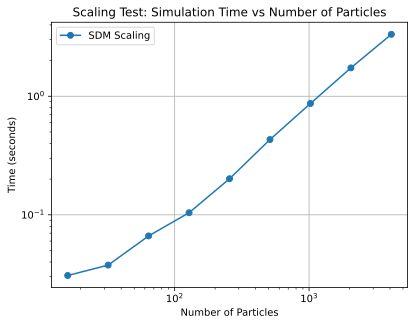

In [14]:
def test_scaling_time_v2(start_exponential, end_exponential, sim_function):
    """
    Tests the scaling of the simulation time with the number of particles.
    """
    time_data = {}
    for i in range(start_exponential, end_exponential + 1):
        n_part = 2**i
        params_comp = SimpleNamespace(n_part=n_part, t_max_s=3600,
                                      n_step=2**(end_exponential - start_exponential))
        params_comp.dt_s = params_comp.t_max_s / params_comp.n_step
        particles = sample(params_phys=PARAMS_PHYS, params_comp=params_comp, rng=RNG)
        start_time = time.time()
        sim_function(particles=particles, params_phys=PARAMS_PHYS, params_comp=params_comp, rng=RNG)
        elapsed_time = time.time() - start_time
        time_data[n_part] = elapsed_time
        print(f"Particles: {n_part}, Time: {elapsed_time:.4f} seconds")
    pyplot.plot(list(time_data.keys()), list(time_data.values()), marker='o', label='SDM Scaling')
    pyplot.xlabel('Number of Particles')
    pyplot.ylabel('Time (seconds)')
    pyplot.title('Scaling Test: Simulation Time vs Number of Particles')
    pyplot.xscale('log')
    pyplot.yscale('log')
    pyplot.grid(True)
    pyplot.legend()
    show_plot()
    return time_data
time_data = test_scaling_time_v2(start_exponential=4, end_exponential=12, sim_function=simulate)


### Conclusion

The extended solver achieves bitwise consistency with the serial version, matches the analytic solution, and demonstrates substantial performance gains on multi-core hardware, all within a concise and maintainable codebase.